# Scikit-learn Beginner's Template - Overtraining Demonstration

This example analysis should demonstrate the effect and consequences of classifier overtraining when splitting the data into a training and a test sample while omitting overfitting checks on an additional validation sample. We will see that our classifier, although perhaps performing excellently on the training data, might fail to generalize well to new data due to overtraining.

For a proper analysis which tries to keep overfitting at a minimum, please see [this notebook](https://github.com/tempse/sklearn-beginners-template/blob/master/example%20analysis%20-%20random%20forest.ipynb).

---

## Table of Contents

- [Example Analysis - Overtraining Demonstration](#Example-Analysis---Overtraining-Demonstration)
    - [Preparatory Steps](#Preparatory-Steps)
    - [Data Import](#Data-Import)
    - [Data Preprocessing](#Data-Preprocessing)
    - [Data Split Into Training and Test Sample](#Data-Split-Into-Training-and-Test-Sample)
    - [Model Definition](#Model-Definition)
    - [Model Training](#Model-Training)
    - [Model Evaluation on the Training Sample](#Model-Evaluation-on-the-Training-Sample)
        - [MVA output distribution](#MVA-output-distribution)
        - [Cut efficiencies plot / MVA cut optimization](#Cut-efficiencies-plot-/-MVA-cut-optimization)
        - [ROC curve](#ROC-curve-1173)
    - [Model Application to the Test Sample](#Model-Application-to-the-Test-Sample)
        - [MVA output distribution](#MVA-output-distribution-1181)
        - [ROC curve](#ROC-curve-1182)
    - [Concluding Remarks](#Concluding-Remarks)

---

## Example Analysis - Overtraining Demonstration

### Preparatory Steps

For our analysis, the following imports are required:

In [1]:
import math
import itertools

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import pandas as pd
from pandas.tools.plotting import scatter_matrix, radviz

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

### Data Import

For this example, we use the [Higgs data set](https://archive.ics.uci.edu/ml/datasets/HIGGS) by Daniel Whiteson (Univ. of California Irvine).

The goal of our analysis will be to distinguish between particle collisions (events) which produce a [Higgs boson](https://en.wikipedia.org/wiki/Higgs_boson) (so-called "signal" events) and processes which don't ("background" events). In other words, we have to deal with a binary classification problem.

The data has been produced using Monte Carlo simulations. It is available as a plain CSV file. Each column in this input file represents an attribute (in the context of machine learning usually referred to as a "feature") of the data, while each row corresponds to an individual event. (For demonstration purposes, a [CSV file containing the first 10 events of the Higgs data set](https://raw.githubusercontent.com/tempse/sklearn-beginners-template/master/data/HIGGS_head.csv) has been uploaded to the repository.)

The first column (`class_label`) contains only zeros and ones, representing signal (`class_label` = 1) and background (`class_label` = 0) events. Columns 2-21 contain quantities that are directly measured by the particle detectors in the accelerator. These features are referred to as _low-level features_. Columns 22-28 are specific (and in general often non-linear) combinations of certain low-level features and are derived by physicists. They are called _high-level features_. The rationale behind constructing these features is to provide a machine learning classifier with "more powerful" features in terms of signal-background discrimination ability. It should be noted at this point that there is growing interest in using deep learning methods to obviate the need for physicists to manually develop such features.

In [3]:
attributes = [
    'class_label', # 1 for signal, 0 for background
    ##########################################################
    'lepton1_pT', # vvv  low-level features (columns 1-22)  vvv
    'lepton1_eta',
    'lepton1_phi',
    'missing_energy_mag',
    'missing_energy_phi',
    'jet1_pT',
    'jet1_eta',
    'jet1_phi',
    'jet1_btag',
    'jet2_pT',
    'jet2_eta',
    'jet2_phi',
    'jet2_btag',
    'jet3_pT',
    'jet3_eta',
    'jet3_phi',
    'jet3_btag',
    'jet4_pT',
    'jet4_eta',
    'jet4_phi',
    'jet4_btag', # ^^^  low-level features  ^^^
    ########################################################
    'm_jj', # vvv  high-level features (columns 22--28)  vvv
    'm_jjj',
    'm_lv',
    'm_jlv',
    'm_bb',
    'm_wbb',
    'm_wwbb' # ^^^  high-level features  ^^^
]

# use pandas to import data from the CSV input file
data = pd.read_csv('./data/higgs/HIGGS.csv',
                   header=None,
                   sep=',',
                   names=attributes,
                   usecols=range(0,22), # only import specific columns
                   nrows=2000000 # only import a certain number of events (usually determined by memory, training time,...)
                  )

In order to utilize machine learning libraries like scikit-learn, we have to set up our data in form of a feature matrix `X` and a target vector `y`.

`X` contains all events (one event per row) which are characterized by a certain number of attributes/features (organized in columns). Thus, the dimensions of `X` are (number of events)x(number of features).

`y` is a (one-dimensional) vector containing the class labels in form of zeros ("background") and ones ("signal").

This form of data preparation can easily be achieved using the following lines of code.

In [4]:
X = data.drop(['class_label'], axis=1)
y = (data['class_label']).astype(int)

print('Dimensions of feature matrix X: ', X.shape)
print('Dimensions of target vector y:  ', y.shape)

Dimensions of feature matrix X:  (2000000, 21)
Dimensions of target vector y:   (2000000,)


Often, it is important to know whether the dataset is "balanced" (i.e., having about the same number of signal and background events) or "imbalanced" (i.e., containing more events of one class than of the other) when training a classifier and evaluating its performance.

One can learn about the "imbalancedness" of the dataset by looking at the absolute numbers of events in the respective classes.

In [5]:
print('\nTotal number of events in data sample: %d' % X.shape[0])
print('Number of signal events in data sample: %d (%.2f percent)' % (y[y==1].shape[0], y[y==1].shape[0]*100/y.shape[0]))
print('Number of backgr events in data sample: %d (%.2f percent)' % (y[y==0].shape[0], y[y==0].shape[0]*100/y.shape[0]))


Total number of events in data sample: 2000000
Number of signal events in data sample: 1058818 (52.94 percent)
Number of backgr events in data sample: 941182 (47.06 percent)


---

### Data Preprocessing

In order to center the data before letting a classifier train on it, we have to subtract the mean and divide by the standard deviation. This has to be separately done for each input feature.

Naturally, scikit-learn provides us with a pre-implemented routine which we can use to do just that.

In [6]:
scaler = StandardScaler()

# first finds the correct values for the mean and the standard deviation ("fit") and
# then transforms the data using these values ("transform")
X = scaler.fit_transform(X)

### Data Split Into Training and Test Sample

Usually, one would split the data into a training, a validation and a test sample. The classifier would be trained on the training sample while the validation sample would be used for overtraining checks. Once properly trained, the actual performance of the classifier would be evaluated on the test sample.

Here, however, we want to demonstrate the effect of overtraining on the classifier performance and show what happens when we fool ourselves by not choosing a proper training/validation/test split. In order to do so, we create a training and a test sample, but no validation sample.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)

print('Number of training samples:   %d' % X_train.shape[0])
print('Number of test samples:       %d' % X_test.shape[0])

Number of training samples:   1000000
Number of test samples:       1000000


### Model Definition

By the way of example, we use a "random forest" as a classifier (see the scikit-learn user's guide ([here](http://scikit-learn.org/stable/modules/ensemble.html#forest) or [here](http://scikit-learn.org/stable/modules/tree.html)) and the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for more information on the `RandomForestClassifier`).

Below are the classifier parameters. These parameters always have to be set by the user and strongly influence the performance of the classifier on a given dataset. Unfortunately, these so-called _hyperparameters_ are problem-specific and there are no general rules which indicate the "correct" set of hyperparameters for a given classification task. Therefore, one usually has to (randomly or systematically) try many different settings in order to find an acceptably well performing set of parameters. Often, however, there are some recommendations on how to start off dealing with new data for the first time (see, e.g., [here](http://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use) for general guidelines on how to use random forests).

In this example, however, we want our classifier to overtrain on the training sample. One way of achieving this might be, e.g., to grow very few, but very deep trees. Let's settle on the following set of hyperparamters:

In [8]:
clf = RandomForestClassifier(n_estimators=10,
                             criterion='gini',
                             max_depth=None,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features=None,
                             max_leaf_nodes=None,
                             min_impurity_split=1e-07,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=-1,
                             random_state=None,
                             verbose=0,
                             warm_start=False,
                             class_weight=None)

### Model Training

The actual training of the model is invoked by calling the `fit` method.

In [9]:
clf = clf.fit(X_train, y_train)

As a quick and first classifier evaluation step, we compute the classification accuracy on the training and the test set. The accuracy is defined as the number of correctly classified events divided by the total number of events.

In [10]:
print("Accuracy on training set:   {:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy on test set:       {:.3f}".format(clf.score(X_test, y_test)))

Accuracy on training set:   0.968
Accuracy on test set:       0.626


We can already see the big difference between the two accuracy values, which is already an indicator of overtraining: The trained classifier performs very well on the training sample, but it fails to make similarly accurate predictions on the test sample. (Normally, at this point, we would want to choose different hyperparameters in order to achieve scores that are similar on the two data samples. But let's keep on overtraining...)

---

### Model Evaluation on the Training Sample

After the classifier has been trained, we first want to investigate its performance on the training sample. In what follows, several methods of classifier evaluation are shown.

In [11]:
# definition of general plotting parameters
nbins = 100

The classifier is presented with the training data (i.e., `X_train`) which we want it to make predictions on. This is done by invoking a "predict" function like `predict_proba(X)`. (See the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict) for other predict functions.)

In [12]:
y_train_score = clf.predict_proba(X_train)

`y_train_score` consists of two columns ('background' and 'signal'), each column containing the predicted probability values for the respective event to be either "background" or "signal".

_NB: In the case of binary classification, the value of a given event in one column uniquely determines the corresponding value in the other column. The reason for this is that all values of a row have to add up to one (i.e., an event is either "background" or "signal" - there is no third option). For the following steps, it is therefore sufficient to process only one of the two columns, since it already contains all the information._

#### MVA output distribution

The following function plots the classifier predictions as a histogram. Additionally, the underlying distributions for the "true signal" and the "true background" are plotted on top of them and returned by the function as arrays.

It is this output distribution which we eventually have to make a cut on in order to classify new data in the future.

In [13]:
def plot_MVAoutput(y_truth, y_score, nbins=100):
    """
    Plots the MVA output as histogram and returns the underlying
    distributions of the positive and the negative class.
    """
    
    # split the array and use only the column containing the
    # probabilities of an event to belong the the "signal" class
    # (can be done in case of 'binary' classification)
    discard, y_score_posClass = np.split(y_score,
                                         2,
                                         axis=1)
    
    y_score_posClass_truePos = y_score_posClass[np.array(y_truth==1)]
    y_score_posClass_trueNeg = y_score_posClass[np.array(y_truth==0)]
    
    plt.figure()

    n_total, bins_total, patches_total = \
        plt.hist(y_score[:,1],
                 bins=nbins,
                 alpha=.25,
                 color='black',
                 label='MVA output')
    
    n_trueNeg, bins_trueNeg, patches_trueNeg = \
        plt.hist(y_score_posClass_trueNeg,
                 bins=nbins,
                 alpha=0.5,
                 color='#dd0000',
                 label='true negative')
    
    n_truePos, bins_truePos, patches_truePos = \
        plt.hist(y_score_posClass_truePos,
                 bins=nbins,
                 alpha=0.5,
                 color='green',
                 label='true positive')
    
    plt.title('MVA output distribution (positive class)')
    plt.xlim(-0.05, 1.05)
    plt.xlabel('MVA output')
    plt.ylabel('Entries')
    plt.legend()
    
    return n_truePos, n_trueNeg

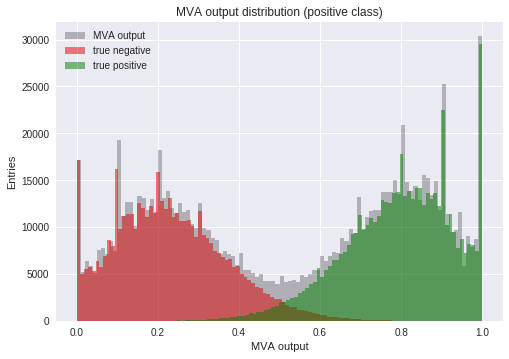

In [14]:
n_truePos, n_trueNeg = plot_MVAoutput(y_train, y_train_score, nbins)

#### Cut efficiencies plot / MVA cut optimization

Now we have to choose an appropriate cut value on the MVA output distribution above. In order to do so, we first perform a scan over the entire MVA output range and calculate signal efficiency, background efficiency and significance for each step in the scan.

Let's consider what happens in a single step of the scan, at a particular MVA output value $x\in[0,1]$: The signal efficiency is defined as the number of signal events $S$ above $x$ (i.e., the number of signal events which pass the momentarily applied MVA cut) divided by the total number of signal events in the data sample. Mathematically: $\text{Eff}_\text{S}=\frac{\text{S}({\text{MVA}\geq x})}{\text{S}({0\leq\text{MVA}\leq 1})}$. Similarly, the background efficiency is given by the number of background events $B$ above $x$ divided by the total number of background events: $\text{Eff}_\text{B}=\frac{\text{B}({\text{MVA}\geq x})}{\text{B}({0\leq\text{MVA}\leq 1})}$. Eventually, the significance at a given MVA output $x$ is calculated to be $\text{Sign}_x = {\text{S}(\text{MVA}\geq x)}\big/{\sqrt{\text{S}(\text{MVA}\geq x)+\text{B}(\text{MVA}\geq x)}}$.

We finally determine the optimal MVA cut as the MVA output value at which the significance distribution has its maximum. In the following plot, this point is marked by a small circle.

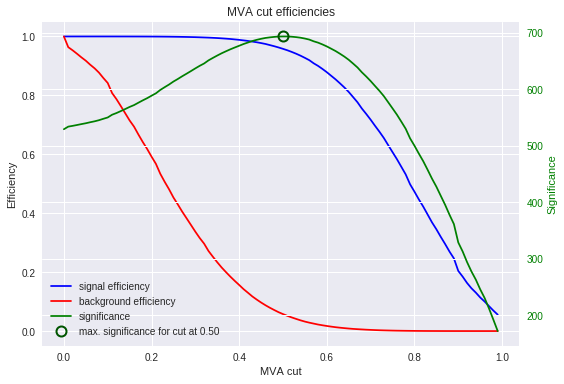

In [15]:
MVAcut = np.empty((0))

plt.figure()
fig, ax1 = plt.subplots()
signal_efficiency = np.empty((0))
backgr_efficiency = np.empty((0))
for i in range(nbins):
    signal_efficiency = np.append(signal_efficiency, \
                                  np.sum(n_truePos[i:n_truePos.shape[0]]) / np.sum(n_truePos))
    backgr_efficiency = np.append(backgr_efficiency, \
                                  np.sum(n_trueNeg[i:n_trueNeg.shape[0]]) / np.sum(n_trueNeg))
    MVAcut = np.append(MVAcut, i/(nbins*1.0))
l1 = ax1.plot(MVAcut, signal_efficiency, label='signal efficiency', color='blue')
l2 = ax1.plot(MVAcut, backgr_efficiency, label='background efficiency', color='red')
ax1.set_xlabel('MVA cut')
ax1.set_ylabel('Efficiency')

ax2 = ax1.twinx()
significance_per_MVAcut = np.empty((0))
for i in range(nbins):
    significance_per_MVAcut = np.append(significance_per_MVAcut, \
                                        np.sum(n_truePos[i:n_truePos.shape[0]]) / \
                                        math.sqrt(np.sum(n_truePos[i:n_truePos.shape[0]] + \
                                                         n_trueNeg[i:n_trueNeg.shape[0]])))
    
l3 = ax2.plot(MVAcut, significance_per_MVAcut,
              label='significance',
              color='green')
pos_max = np.argmax(significance_per_MVAcut)
MVAcut_opt = pos_max/(nbins*1.0)
l4 = ax2.plot(pos_max/(nbins*1.0), significance_per_MVAcut[pos_max],
              label='max. significance for cut at %.2f' % MVAcut_opt,
              marker='o', markersize=10, fillstyle='none', mew=2, linestyle='none',
              color='#005500')
ax2.set_ylabel('Significance', color='green')
ax2.tick_params('y', colors='green')

plt.title('MVA cut efficiencies')
lall = l1+l2+l3+l4
labels = [l.get_label() for l in lall]
ax2.legend(lall, labels, loc='lower left')
plt.tight_layout()

The above-determined MVA cut value is stored in the variable `MVAcut_opt` and used throughout the rest of the code whenever an MVA cut is performed.

#### ROC curve

A common way of characterizing the performance of a trained classifier is to plot the so-called [Receiver Operating Characteristic](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) curve - or short: the ROC curve.

The ROC curve contains the values for true positive rates (number of correctly classified signal events divided by the total number of signal events) and false positive rates (number of incorrectly classified signal events divided by the total number of background events) for all possible MVA cut values. The greater the area under the ROC curve (short: ROC AUC), the better the classifier performance on the particular dataset. A ROC AUC of 0.5 means that the classifier does not perform better than a dummy classifier which _randomly_ assigns events to their classes.

In the ROC plot below, which is drawn from predictions on the training sample, we additionally highlight the working point corresponding to the optimized MVA cut value.

In [16]:
def plot_ROCcurve(y_truth, y_score, workingpoint=-1):
    """
    Plots the ROC curve and (if specified) the chosen working point.
    """
    
    fpr, tpr, thresholds = roc_curve(y_truth, y_score[:,1], pos_label=1)
    roc_auc = roc_auc_score(y_truth, y_score[:,1])
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    
    if workingpoint != -1:
        # find and plot threshold closest to the chosen working point
        close_MVAcut_opt = np.argmin(np.abs(thresholds-workingpoint))
    
        plt.plot(fpr[close_MVAcut_opt], tpr[close_MVAcut_opt], 'o', markersize=10,
                 label="threshold at %.2f" % workingpoint, fillstyle="none",
                 mew=2)
    
    plt.legend(loc=4)

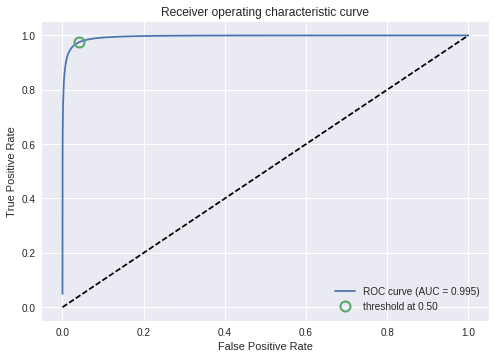

In [17]:
plot_ROCcurve(y_train, y_train_score, MVAcut_opt)

We see that our classifier performs very well on the training sample (i.e., a ROC AUC close to 1). It is capable of distinguishing signal from background events very accurately. So let's apply the classifier to the test sample and see how it performs on new data.

---

### Model Application to the Test Sample

Up until now, we have chosen a set of hyperparameters which performs excellently on the training sample. (However, we did not perform overtraining checks on a separate validation sample as we should have done, were it not for the sake of overtraining demonstration.)

With the training phase of our analysis thus being concluded, we want to apply the classifier to the held-out test sample. It is important to note that we are not allowed to change the classifier hyperparameters anymore at this point since this would bias the final classifier evaluation results!

In order to assess the generalization ability of the trained classifier, we proceed analogously to before.

In [18]:
y_test_score = clf.predict_proba(X_test)

#### MVA output distribution

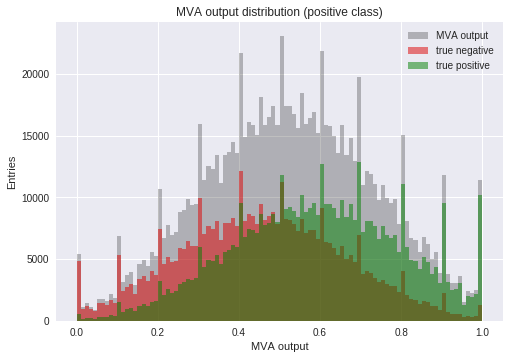

In [19]:
n_truePos, n_trueNeg = plot_MVAoutput(y_test, y_test_score)

#### ROC curve

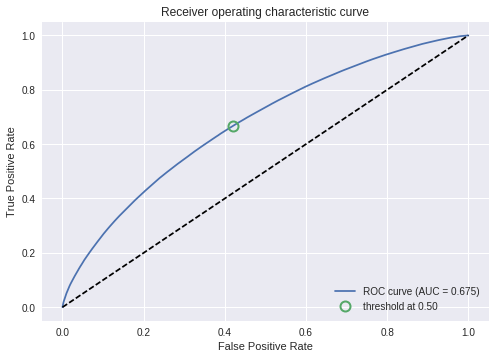

In [20]:
plot_ROCcurve(y_test, y_test_score, MVAcut_opt)

From the above plots we can conclude that the classifier performs much more poorly on the test sample compared to the training sample. Apparently, it has more troubles disentangling signal from background events, which results in a much lower ROC AUC. We expected this, since we deliberately let the classifier overtrain on the training sample.

There is one more important detail to make a note of: Evaluating the test sample performance of the overtrained classifier and a not-overtrained classifier (see [this notebook](https://github.com/tempse/sklearn-beginners-template/blob/master/example%20analysis%20-%20random%20forest.ipynb)), we observe that the test sample ROC AUCs of the two are different: The properly trained classifier achieves a ROC AUC of more than 80% on the test data, while here we have much less than 70%. This means that, in case of overtraining, there is not only a difference between training and test sample performance of the classifier, but the overtrained classifier usually also performs worse on new data than a properly-trained one. To put it differently, an overtrained classifier fails to _generalize_ well to new data.

Overtraining does _not_ introduce a systematic error, but the performance of a classifier suffers from it. So we obviously want to keep overtraining at a minimum. The usual way of getting a handle on overtraining is to split the data not into two distinct samples, but into three: a training, a validation and a test sample. In this setup, the classifier training is done on the training sample, while the validation sample is used to monitor overtraining and get a handle on it. Once this is done (and only then), the classifier performance is evaluated on the independent test set. For a complete example of a proper data split, please refer to [this notebook](https://github.com/tempse/sklearn-beginners-template/blob/master/example%20analysis%20-%20random%20forest.ipynb).

### Concluding Remarks

Hopefully, the effects and consequences of overtraining have become clear from the above example.

As a concluding note, let me point out that the onset of overtraining for a given classifier does not only depend on its hyperparameters, but also on the dataset it's trained on. For instance, changing the data sample size can influence the classifier performance on the test sample. Let's observe this behavior with a data sample of half the size as before:

In [21]:
num_samples = int(X_train.shape[0]*0.5)

clf = clf.fit(X_train[0:num_samples,:], y_train[0:num_samples])

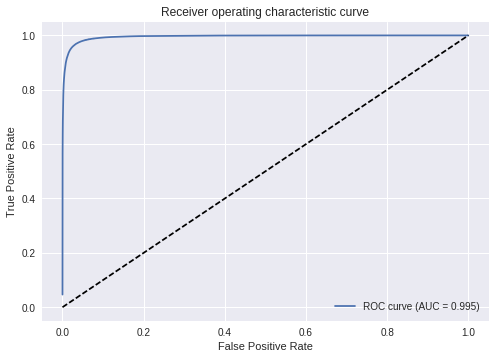

In [22]:
plot_ROCcurve(y_train[0:num_samples], clf.predict_proba(X_train[0:num_samples]))

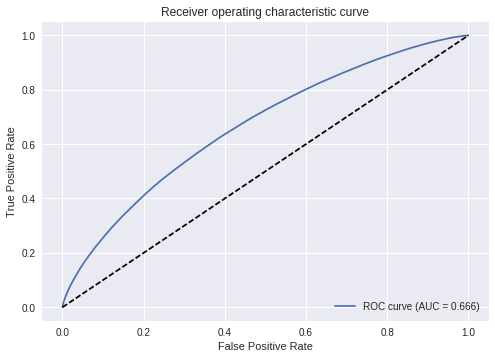

In [23]:
plot_ROCcurve(y_test[0:num_samples], clf.predict_proba(X_test[0:num_samples]))

As we can see based on the ROC AUCs, reducing the data size makes the classifier perform even worse on the test sample. A possible explanation for this could be the following: For less and less data, the high-dimensional feature space becomes less and less densely filled with data points. This results in the classifier to be trained in a very sparsely filled feature space volume in which the data point distribution fluctuates considerably from sample to sample. Thus, having a large number of features and a small amount of data might hinder the classifier from becoming capable of generalizing well to new data. Conversely, this means that the more data we use for training, the less likely overtraining occurs for a classifier of given complexity.

In real world applications, the amount of training data is often very limited and we can't really afford to split off a properly-sized validation sample, because we would lose a big percentage of training data in doing so. We won't go into detail here on how to tackle this problem, but let me just refer to the concept of [cross validation](http://scikit-learn.org/stable/modules/cross_validation.html) as a possible and commonly-used solution.